# Trip Itinerary Planning

**Authors:** Jingkai Jia, Yuli Chen and Yuxuan Liu<br>
**Course:** ECE1724H: Bio-inspired Algorithms for Smart Mobility - Fall 2021<br>
**Instructor:** Dr. Alaa Khamis<br>
**Department:** Edward S. Rogers Sr. Department of Electrical & Computer Engineering, University of Toronto

## Introduction

The Trip Itinerary Problem (TIP) consists of a problem where a list of locations to visit must be selected, and have routes formulated between them, such that some sort of cost function (such as number of visited places, POI ranking, traveller satisfaction, etc) is maximized. <br>

Essentially, the problem can be broken down into the following:

1. Select a subset from a set of POIs (or candidate points).
2. Construct one or more routes between a home point (like a hotel, etc.) and those points, in order to satisfy time and distance constraints.


In [44]:
from ipyleaflet import AntPath,Map,Marker
from ipywidgets import HTML
import osmnx as ox
import pandas as pd
import numpy as np
import os
import requests
import json
import random
import time
import folium
import folium.plugins
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import OrderedDict
from itertools import combinations
from smart_mobility_utilities.poi import number_DivIcon

## Dataset

This implementation uses a dataset compiled from a [public source listing POIs and Attractions in Toronto](https://ckan0.cf.opendata.inter.prod-toronto.ca/tr/dataset/places-of-interest-and-toronto-attractions), supplemented with further data from mapping APIs such as Google Maps API.

A total of 165 POIs exist in the dataset.

Additionally, a precomputed matrix of distances between POIs was created in order eliminate the need for real-time distance queries and speed up the algorithm running times.

## Problem Formulation

### Variables

$V_i$ : poi i<br>
$R_i$ : rating of $V_i$<br>
$C_{ij}$ : the time it takes for the user to travel from $V_i$ to $V_j$<br>
$L_{ij}$ : the distance between $V_i$ and $V_j$<br>
$O_i,E_i$ : the openning/closing time of $V_i$<br>
$D_i$ : duration visitor want to spend on $V_i$<br>
$S_i$ : the time when the visitor arrives $V_i$<br>
$a_{ijk}$ : whether $V_j$ is visited after $V_i$ in tour $k$. True -> 1, False -> 0<br>
$b_{ij}$ : whether $V_i$ is visited in tour $j$. True -> 1, False -> 0<br>
$m$ : the number of tours a visitor wants to take<br>
$\gamma$ : weight of soft constraint<br>
$ T_{start}, T_{end}$ : start and end time of the tour<br>
$Q$ : a large positive constant used for integer programming modelling

### Objective

$\sum_{i=0}^{m} \sum_{j=1}^{n} R_i b_{ij} - \sum_{i=1}^{n} \sum_{j=1}^{n}  \sum_{k=1}^{m} \gamma L_{ij} a_{ijk}$

### Constraints

$\sum_{i=0}^{m} \sum_{j=1}^{n} a_{1ij} = \sum_{i=0}^{m} \sum_{j=1}^{n} a_{nij} = m$ (m tours are start from V1
and end with Vn)

$\sum_{i=2}^{n-1} \sum_{j=1}^{m} b_{ij} \le 1$ (all vertices
are visited only once)

$\sum_{i=1}^{n-1} a_{ijk} = b_{kj}, k=2,...,n-1; j=1,...,m$ (all tours are connected, used together with the constraint below)

$\sum_{i=2}^{n} a_{ijk} = b_{kj}, k=2,...,n-1; j=1,...,m$ (all tours are connected, used together with the constraint above)

$S_{ik} + D_{i} + C_{ij} - S_{jk} \le Q(1-a_{ijk}), \> i=1,...,n-1;j = 2,... n; k = 1,...,m$ (travel time is continuous)

$O_{i} \le S_{ij} + D_{i} \le E_{i}, \> i = 1,...,n; j = 1,...,m$ (vertices are visited within the time window)


## Data Object

The following class stores information about POIs, as well as loads POI distance information from the precomputed matrix.

In [45]:
class POI:
    def __init__(self, name, id, category, lat, lng, rating=None, openings=None):
        self.name = name
        self.id = id
        self.category = category
        self.coordinates = (lat,lng)
        if np.isnan(lat) or np.isnan(lng):
            self.coordinates = (0,0)
        self.rating = rating
        self.visit_duration = 100.0
        self.open_time, self.close_time = openings
        
        self.open_time = self.open_time // 100 * 60 + self.open_time % 100
        self.close_time = self.close_time // 100 * 60 + self.close_time % 100
        self.BASE_DIR = ""
        self.route_cache = dict()
        self.min_duration = float('inf')
        if self.id >= 0:
            self.warm_cache()
        
    def warm_cache(self):
        from_id = int(self.id)
        
        df = pd.read_csv('{}cache/poi_pair_cost_{}.csv'.format(self.BASE_DIR, from_id))
        with open('cache/coords_db_{}.json'.format(from_id)) as f:
            coord_db = json.loads(f.read())
        
        for index, row in df.iterrows():
            result = {
                'coords': None,
                'length': None,
                'duration': None
            }
            to_id = int(row['to_id'])
            result['duration'] = float(row['duration']) / 60.0
            self.min_duration = min(self.min_duration, result['duration'])
            result['length'] = float(row['length'])
            result['coords'] = coord_db[str(from_id)][str(to_id)]
            self.route_cache[(from_id, to_id)] = result
            
        
        
    def query_route_db(self, from_id, to_id):
        if (from_id, to_id) not in self.route_cache:
            result = {
                'coords': None,
                'length': None,
                'duration': None
            }
            df = pd.read_csv('{}cache/poi_pair_cost_{}.csv'.format(self.BASE_DIR, from_id))
            
            result['duration'] = float(df[ df['to_id'] == to_id ]['duration']) / 60.0
            result['length'] = float(df[ df['to_id'] == to_id ]['length'])
            with open('cache/coords_db_{}.json'.format(from_id)) as f:
                result['coords'] = json.loads(f.read())[str(from_id)][str(to_id)]
            self.route_cache[(from_id, to_id)] = result
        else:
            result = self.route_cache[(from_id, to_id)]
        return result

    def route_to(self, destination, mode = "driving"):
        from_id = self.id
        to_id = destination.id
        try:
            result = self.query_route_db(from_id, to_id)
        except:
            print(from_id, to_id)
            raise
        return result
    
    def __eq__(self, other):
        return self.id == other.id

    def __hash__(self):
        return self.id
    
    def __repr__(self):
        return f"ID: {self.id}, Name: {self.name}, Score: {self.rating}"

def get_pois(file):
    df = pd.read_csv(file)
    my_pois = []
    for i, row in df.iterrows():
        name,category,geoid,lat,lng,rating,openings,closings = row.values.tolist()
        poi = POI(name, i, category, lng, lat , rating, (openings, closings))
        my_pois.append(poi)
    return my_pois


def getRouteBounds(tours):
    for tour in tours:
        route = [ (t.coordinates[1], t.coordinates[0]) for t in tour]
        minLat = min(route, key=lambda x:x[0])
        maxLat = max(route, key=lambda x:x[0])
        minLng = min(route, key=lambda x:x[1])
        maxLng = max(route, key=lambda x:x[1])
    return [(minLat, minLng), (maxLat, maxLng)]

## Problem Class

In [46]:
class Problem:
    def __init__(self, use_soft_constraint=False, alpha=1e-5, number_of_tour=2):
        self.pois = get_pois('pois.csv')
        self.home_poi = POI('Home', 166, 'HOME',  -79.3969, 43.6596,  rating=0, openings=(900, 1700))
        self.number_of_tour = number_of_tour
        self.id_pois_map = { poi.id: poi for poi in self.pois}
        self.evaluation_cache = {}
        for i in range(self.number_of_tour-1):
            self.id_pois_map[-(i+1)] = POI('Spliter', -(i+1), 'SPL', 0,0,  rating=0, openings=(0, 0))
        self.use_evaluation_cache = True
        # if use soft constraint, we apply some penalty to the evaluation function wrt the length driving
        self.use_soft_constraint = use_soft_constraint
        self.alpha = alpha
        self.min_duration = [poi.min_duration for poi in self.pois]
        
    def reset(self):
        use_soft_constraint = self.use_soft_constraint
        alpha = self.alpha
        number_of_tour = self.number_of_tour
        self.__init__(use_soft_constraint, alpha, number_of_tour)

    
    def navie_decode(self, gaint_tour):
        '''
        split a gaint tour into a list of single tour
        with out feasibility check
        
        example
        >> a = [1,3,-1,2,4]
        >> b = naive_decode(a)
        >> b # 5 is the id for home
        [ [5, 1, 3, 5],
          [5, 2, 4, 5] ]
        '''
        solution = []
        tour = []
        gaint_tour = [self.home_poi] + gaint_tour
        for poi in gaint_tour:
            if poi.id < 0:
                tour.append(self.home_poi)
                solution.append(tour)
                tour = [self.home_poi]
            else:
                tour.append(poi)
        solution.append(tour)
        solution[-1].append(self.home_poi)
        return solution
    
    def can_visit(self, current_time, current_poi, next_poi):
        if current_time + current_poi.route_to(next_poi)['duration'] + next_poi.visit_duration> next_poi.close_time:
            return False
        tentative_arrive_time = max(next_poi.open_time, current_time + current_poi.route_to(next_poi)['duration'])
        tentative_leave_time = tentative_arrive_time + next_poi.visit_duration
        earliest_back_home_time = tentative_leave_time + next_poi.route_to(self.home_poi)['duration']
        if earliest_back_home_time > self.home_poi.close_time:
            return False
        return True
    
    def filter_infeasible_pois(self, tour):
        current_time = None
        feasible_tour = []
        for i, next_poi in enumerate(tour):
            if i == 0:
                current_time = next_poi.open_time
                current_poi = next_poi
                feasible_tour.append(current_poi)
                continue
            if next_poi == self.home_poi:
                feasible_tour.append(self.home_poi)
                break
            
            if self.can_visit(current_time, current_poi, next_poi):
                current_time = max(next_poi.open_time, current_time + current_poi.route_to(next_poi)['duration']) + next_poi.visit_duration
                current_poi = next_poi
                feasible_tour.append(current_poi)            
        return feasible_tour
    
    def build_feasible_solution(self, solution):
        feasible_soluion = []
        for tour in solution:

            feasible_tour = self.filter_infeasible_pois(tour)
            feasible_soluion.append(feasible_tour)

        return feasible_soluion
        
            
    def gaint_tour_decode(self, gaint_tour):
        infeasible_solution = self.navie_decode(gaint_tour)
        feasible_solution = self.build_feasible_solution(infeasible_solution)                
        return feasible_solution
                    
    
    def get_initial_soluton(self, mode='random'):
        if mode == 'random':
            gaint_tour = random.sample([poi.id for poi in self.pois], len(self.pois))
            for i in range(self.number_of_tour - 1):
                gaint_tour.insert(random.randrange(len(gaint_tour)+1), -(i+1))
        return gaint_tour
    
    def evaluate(self, gaint_tour):
        if self.use_evaluation_cache and tuple(gaint_tour) in self.evaluation_cache:
            return self.evaluation_cache[tuple(gaint_tour)]
        gaint_poi_tour = [self.id_pois_map[i] for i in gaint_tour]
        solution = self.gaint_tour_decode(gaint_poi_tour)
        score = 0.0
        for tour in solution:
            for poi in tour:
                score += poi.rating
            if self.use_soft_constraint:
                score -= self.alpha * (self.get_tour_length(tour))
        if self.use_evaluation_cache and tuple(gaint_tour) not in self.evaluation_cache:
            self.evaluation_cache[tuple(gaint_tour)] = score
        return score
    
    @staticmethod
    def draw_tours(tours):
        center = [43.6596,-79.3969]
        m = folium.Map(zoom_start = 12)
        bounds = getRouteBounds(tours)
        m.fit_bounds(bounds)
        color_set = ['yellow','green','red','blue']
        for tour in tours:
            tour_route = []
            color = color_set.pop()
            i = 1
            for u,v in zip(tour[0:],tour[1:]):
                if i == len(tour) - 1:
                    i = 0
                folium.Marker(location=list(v.coordinates)[::-1], icon=folium.Icon(color='white', icon_color='white')).add_to(m)
                folium.Marker(location=list(v.coordinates)[::-1],  icon=number_DivIcon(color,i)).add_to(m)
                r = u.route_to(v)['coords']
                tour_route += r
                i += 1
            ant_path = folium.plugins.AntPath(
                locations=[
                    tour_route
                ],
                dash_array=[1, 10],
                delay=1000,
                color=color,
            )
            ant_path.add_to(m)
        return m
    
    @staticmethod
    def get_tour_length(tour):
        length = 0
        for u,v in zip(tour[0:],tour[1:]):
            if u != v:
                length += u.route_to(v)['length']
        return length

## GA Solver

A solution class for Genetic Algorithm

In [47]:
class GeneticAlgorithmSolver:
    def __init__(self, population_size=20):
        
        self.global_solution = None
        self.global_score = float('-inf')
        
        self.max_geneartions = 1000
        self.population = []
        self.population_size = population_size
        self.problem = None
        self.mutation_prob = 0.1
        self.crossover_prob = 0.7

        self.adaptive = False
        self.converge_threshold = 0.1
        self.fitness_level = 1.0
        
        self.score_history = []
        self.converge_history = []
        self.terminate_threshold = float('-inf')
        
        
    def reset(self):
        population_size = self.population_size
        self.__init__(population_size)
        
        
        
    def update_global(self, score, solution):
        if score > self.global_score:
            self.global_solution = solution
            self.global_score = score
            
    
    def pmx(self, a, b):
        c = [None] * len(a)
        start = random.randint(0, len(a)//2 - 1)
        kept_idx = set([i for i in range(start, start+len(a)//2)])
        kept_val = {a[i] for i in kept_idx}
        for i in kept_idx:
            c[i] = a[i]
            if b[i] in kept_val:
                continue
            val = a[i]
            j = b.index(val)
            while j in kept_idx:
                val = a[j]
                j = b.index(val)          
            c[j] = b[i]
        for i in range(len(c)):
            if c[i] is None:
                c[i] = b[i]
        return c
        
        
    def permutation_cross_over(self, a, b, mode='pmx'):
        if mode == 'pmx':
            child = self.pmx(a, b)
        return child
    
    def mutate(self, individual):
        if self.adaptive:
            mutation_prob = self.mutation_prob * ( 1.0 / (self.fitness_level + 1e-2) )
        else:
            mutation_prob = self.mutation_prob
            
        if mutation_prob > np.random.uniform():
            for i in range( int( 1 + 1.0 / (self.fitness_level + 1e-2) ) ):
                idx = range(len(individual))
                c1, c2 = random.sample(idx, 2)
                individual[c1], individual[c2] = individual[c2], individual[c1]
        return individual
        
        
    def generate_next(self, population):
        next_generation = population[:]
        for i in range(10):
            if len(population) <= 2:
                break
            if self.crossover_prob > np.random.uniform():
                parent_a = population.pop(random.randrange(0, len(population)))
                parent_b = population.pop(random.randrange(0, len(population)))
                child = self.permutation_cross_over(parent_a, parent_b)
                child = self.mutate(child)
                next_generation.append(child)
        
        return next_generation
    
    def select(self, population):
        score_board = []
        for individual in population:
            score = self.problem.evaluate(individual)
            self.update_global(score, individual)
            score_board.append( [score, individual] )
        score_board.sort(key=lambda x: x[0], reverse=True)
        scores = [x[0] for x in score_board]
        score_board = [x[1] for x in score_board]

        self.converge_history.append(np.average(scores[:self.population_size]))

        next_gen = score_board[:self.population_size]
        if self.adaptive and np.var(scores) < self.converge_threshold:
            for i in range(self.population_size//2, self.population_size):
                random.shuffle(next_gen[i])
        if self.adaptive:
            self.fitness_level = np.var(scores)
        
        return next_gen
                
    def solve(self, problem):
        self.problem = problem
        for _ in range(self.population_size):
            individual = problem.get_initial_soluton()
            score = problem.evaluate(individual)
            self.update_global( score, individual)
            self.population.append(individual)
        for geneartion in tqdm(range(self.max_geneartions)):
            next_population_candidates = self.generate_next(self.population)
            self.population = self.select(next_population_candidates)
            self.score_history.append(self.global_score)
        return geneartion

## Adaptive GA Solver

Adaptive variant of GA Solver

In [48]:
import numpy as np

class AdaptiveGeneticAlgorithmSolver:
    def __init__(self, population_size=20):
        
        self.global_solution = None
        self.global_score = float('-inf')
        
        self.max_geneartions = 1000
        self.population = []
        self.population_size = population_size
        self.problem = None
        self.mutation_prob = 0.1
        self.crossover_prob = 0.7

        self.adaptive = True
        self.converge_threshold = 0.1
        self.fitness_level = 1.0
        
        self.score_history = []
        self.converge_history = []
        self.terminate_threshold = float('-inf')
        
        
    def reset(self):
        population_size = self.population_size
        self.__init__(population_size)
        
        
        
    def update_global(self, score, solution):
        if score > self.global_score:
            self.global_solution = solution
            self.global_score = score
            
    
    def pmx(self, a, b):
        c = [None] * len(a)
        start = random.randint(0, len(a)//2 - 1)
        kept_idx = set([i for i in range(start, start+len(a)//2)])
        kept_val = {a[i] for i in kept_idx}
        for i in kept_idx:
            c[i] = a[i]
            if b[i] in kept_val:
                continue
            val = a[i]
            j = b.index(val)
            while j in kept_idx:
                val = a[j]
                j = b.index(val)          
            c[j] = b[i]
        for i in range(len(c)):
            if c[i] is None:
                c[i] = b[i]
        return c
        
        
    def permutation_cross_over(self, a, b, mode='pmx'):
        if mode == 'pmx':
            child = self.pmx(a, b)
        return child
    
    def mutate(self, individual):
        if self.adaptive:
            mutation_prob = self.mutation_prob * ( 1.0 / (self.fitness_level + 1e-2) )
        else:
            mutation_prob = self.mutation_prob
            
        if mutation_prob > np.random.uniform():
            for i in range( int( 1 + 1.0 / (self.fitness_level + 1e-2) ) ):
                idx = range(len(individual))
                c1, c2 = random.sample(idx, 2)
                individual[c1], individual[c2] = individual[c2], individual[c1]
        return individual
        
        
    def generate_next(self, population):
        next_generation = population[:]
        for i in range(10):
            if len(population) <= 2:
                break
            if self.crossover_prob > np.random.uniform():
                parent_a = population.pop(random.randrange(0, len(population)))
                parent_b = population.pop(random.randrange(0, len(population)))
                child = self.permutation_cross_over(parent_a, parent_b)
                child = self.mutate(child)
                next_generation.append(child)
        
        return next_generation
    
    def select(self, population):
        score_board = []
        for individual in population:
            score = self.problem.evaluate(individual)
            self.update_global(score, individual)
            score_board.append( [score, individual] )
        score_board.sort(key=lambda x: x[0], reverse=True)
        scores = [x[0] for x in score_board]
        score_board = [x[1] for x in score_board]
        self.converge_history.append(np.average(scores[:self.population_size]))
        next_gen = score_board[:self.population_size]
        if self.adaptive and np.var(scores) < self.converge_threshold:
            for i in range(self.population_size//2, self.population_size):
                random.shuffle(next_gen[i])
        if self.adaptive:
            self.fitness_level = np.var(scores)
        
        return next_gen
                
    def solve(self, problem):
        self.problem = problem
        for _ in range(self.population_size):
            individual = problem.get_initial_soluton()
            score = problem.evaluate(individual)
            self.update_global( score, individual)
            self.population.append(individual)
        for geneartion in tqdm(range(self.max_geneartions)):
            next_population_candidates = self.generate_next(self.population)
            self.population = self.select(next_population_candidates)
            self.score_history.append(self.global_score)
        return geneartion

## ABC Solver

Solution class for Artificial Bee Colony Solver

In [49]:
class AritificalBeeColonySolver:
    def __init__(self, population_size=20):
        
        self.global_solution = None
        self.global_score = float('-inf')
        
        self.max_iterations = 1000
        self.num_of_bees = population_size
        self.food_sources = []
        self.food_source_size = self.num_of_bees // 2
        
        self.improvement_histories = []
        self.problem = None
        self.pairs = None
        
        self.score_history = []
        self.converge_history = []
        self.terminate_threshold = float('-inf')
        
        
    def reset(self):
        population_size = self.num_of_bees
        self.__init__(population_size)
        
        
    def update_global(self, score, solution):
        if score > self.global_score:
            self.global_solution = solution
            self.global_score = score
      
    def move_around(self, source):
        for i in range(10):
            i, j = random.sample(range(len(source)), 2)
            source[i], source[j] = source[j], source[i]
        return source
    
    def employ_bee_update(self, source_id):
        source = self.food_sources[source_id]
        neighbour = self.move_around(source)
        diff = self.evaluate(neighbour) - self.problem.evaluate(source)
        self.improvement_histories[source_id].append(diff > 0)
        if diff > 0:
            return neighbour
        return source
    
    def get_abandoned(self):
        abandoned = []
        for i, improvement_history in enumerate(self.improvement_histories):
            if len(improvement_history) > 10:
                if sum(improvement_history[-10:]) / 10 <= 0.4:
                    abandoned.append(i)
        return abandoned
    
    def scout_bee_update(self, source_id):
        random.shuffle(self.food_sources[source_id])
        self.evaluate(self.food_sources[source_id])
        self.improvement_histories[source_id] = [True]
        return self.food_sources[source_id]
    
    def evaluate(self, solution):
        score = self.problem.evaluate(solution)
        self.update_global(score, solution)
        return score
                    
                
    def solve(self, problem):
        self.problem = problem
        for _ in range(self.food_source_size):
            food_source = problem.get_initial_soluton()
            self.evaluate(food_source)
            self.food_sources.append(food_source)
            self.improvement_histories.append([True])
        for iteration in tqdm(range(self.max_iterations)):
            for i in range(self.num_of_bees // 2):
                self.food_sources[i] = self.employ_bee_update(i)
                
            for _ in range(self.num_of_bees // 2):
                scores = [ self.evaluate(source) for source in self.food_sources ]
                distribution = [ s / sum(scores) for s in scores ]
                i = random.choices(range(0, self.food_source_size), k=1, weights=distribution)[0]
                self.food_sources[i] = self.employ_bee_update(i)
            
            self.converge_history.append(np.average(scores))

            for i in self.get_abandoned():
                self.food_sources[i] = self.scout_bee_update(i)
            self.score_history.append(self.global_score)
            if len(self.score_history) > 10:
                if np.var(self.score_history[-10:]) < self.terminate_threshold:
                    break
        return iteration

## Solving the Problem

We can solve the problem using different algorithms and compare the results.

For this case, we will assume the following parameters:

In [50]:
p = Problem(use_soft_constraint=True,alpha=1e-5, number_of_tour=2)

### GA Solution

This implementation seeks to produce two tours, using the Genetic Algorithm Solver.

In [51]:
# defaults are max_generations = 1000, population_size = 20
ga = GeneticAlgorithmSolver()
ga.solve(p)
sol = p.gaint_tour_decode([p.id_pois_map[i] for i in ga.global_solution])

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Visualizing Results

In [52]:
Problem.draw_tours(sol)

NameError: name 'loc' is not defined

The final solution has a score of 38.348292


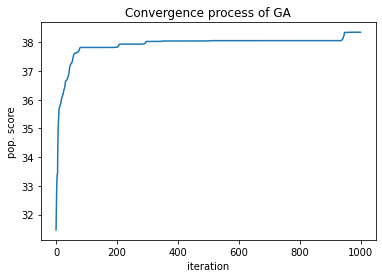

In [ ]:
data = ga.converge_history
plt.plot(list(range(len(data))),data)
plt.title('Convergence process of GA')
plt.xlabel('iteration')
plt.ylabel('pop. score')
print('The final solution has a score of', str(ga.global_score))

### Adaptive GA Solution

In [ ]:
# defaults are max_generations = 1000, population_size = 20
aga = AdaptiveGeneticAlgorithmSolver()
aga.solve(p)
sol = p.gaint_tour_decode([p.id_pois_map[i] for i in  aga.global_solution])

100%|██████████| 1000/1000 [00:01<00:00, 511.04it/s]


#### Visualizing Results

In [ ]:
Problem.draw_tours(sol)

The final solution has a score of 38.455375000000004


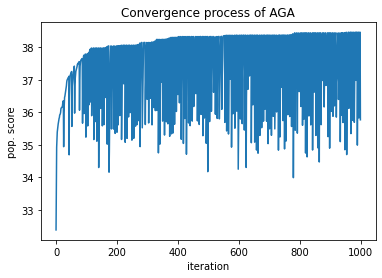

In [ ]:
data = aga.converge_history
plt.plot(list(range(len(data))),data)
plt.title('Convergence process of AGA')
plt.xlabel('iteration')
plt.ylabel('pop. score')
print('The final solution has a score of', str(aga.global_score))

### ABC Solution

In [ ]:
abc = AritificalBeeColonySolver()
abc.solve(p)
sol = p.gaint_tour_decode([p.id_pois_map[i] for i in  abc.global_solution])

100%|██████████| 1000/1000 [00:04<00:00, 216.50it/s]


#### Visualizing Results

In [ ]:
Problem.draw_tours(sol)

The final solution has a score of 37.176791


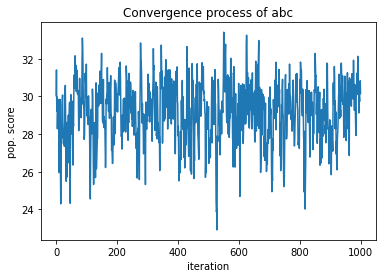

In [ ]:
data = abc.converge_history
plt.plot(list(range(len(data))),data)
plt.title('Convergence process of abc')
plt.xlabel('iteration')
plt.ylabel('pop. score')
print('The final solution has a score of', str(abc.global_score))

## Comparative Analysis

We can also compare the results across the different approaches in terms of wall time, cpu time, score, and optimality.

This can be done by first storing the runtime results in experiment files, and plotting the results side by side.

In [ ]:
class Experiment:
    def __init__(self, problem, solver, num_run=5, cold=True, population_size=20):
        if problem is None:
            return
        self.optimal_score = problem.number_of_tour * 5.0 * 4.0
        self.start_cold = cold
        self.solver = solver
        self.problem = problem
        self.num_run = num_run
        self.population_size = population_size
        self.result = {
            "wall_time":[],
            "cpu_time":[],
            "score":[],
            "optimality":[],
            "num_iteration":[],
        }
        self.score_histories = []
        
    def load_experiment_results(self, file_name):
        with open(file_name) as f:
            result = json.loads(f.read())
        self.optimal_score = result["optimal_score"]
        self.start_cold = result["start_cold"]
        self.num_run = result["num_run"]
        self.population_size = result["population_size"]
        self.result = result["result"]
        self.score_histories = result["score_histories"]
        
    def store_experiment_results(self):
        experiment_result = {
            "optimal_score": self.optimal_score,
            "start_cold": self.start_cold,
            "solver": type(self.solver).__name__,
            "soft_constraint": self.problem.use_soft_constraint,
            "alpha": self.problem.alpha,
            "number_of_tour": self.problem.number_of_tour,
            "num_run": self.num_run,
            "population_size": self.population_size,
            "result": self.result,
            "score_histories": self.score_histories
        }

        file_name = "experiment/{}_{}_{}_{}.json".format(experiment_result["solver"], experiment_result["number_of_tour"], experiment_result["population_size"], int(time.time()))
        with open(file_name, 'w+') as f:
            f.write(json.dumps(experiment_result))
        
    def warm_up_cache(self):
        for _ in range(5):
            self.solver.solve(self.problem)
            self.solver.reset()
            
    def get_mean_result(self):
        mean_result = {}
        for key, value in self.result.items():
            mean_result[key] = round (sum(value) / len(value), 3)
        return mean_result
    
    def get_max_result(self):
        mean_result = {}
        for key, value in self.result.items():
            mean_result[key] = max(value)
        return mean_result
    
    def get_min_result(self):
        mean_result = {}
        for key, value in self.result.items():
            mean_result[key] = min(value)
        return mean_result
    
    def get_mean_global_score_history(self):
        mean_score = []
        history_len = len(self.score_histories[0])
        for i in range(history_len):
            val = 0
            for score_history in self.score_histories:
                val += score_history[i]
            val /= len(self.score_histories)
            mean_score.append(val)
        return mean_score
        
    
    def plot_global_score_history(self):
        for score_history in self.score_histories:
            plt.plot(score_history)
        plt.show()
        
    def plot_mean_global_score_history(self):
        mean_score = self.get_mean_global_score_history()
        plt.plot(mean_score)
        plt.show()
        
    def get_num_iteration_to_pdbk(self, pdbk, score_history):
        score_cut = self.optimal_score - pdbk * self.optimal_score
        for i, score in enumerate(score_history):
            if score >= score_cut:
                return i
        return None
                    
    def get_mean_num_iteration_to_pdbk(self, pdbk):
        cut_points = []
        for score_history in self.score_histories:
            cut_point = self.get_num_iteration_to_pdbk(pdbk, score_history)
            if cut_point is not None:
                cut_points.append(cut_point)
            else:
                cut_points.append(10000)
        return sum(cut_points) / len(cut_points)
        
    def run(self):
        if self.start_cold is False:
            self.warm_up_cache()
        
        for i in range(self.num_run):
            wall_time_start = time.perf_counter()
            cpu_time_start = time.process_time()
            num_iteration = self.solver.solve(self.problem)
            wall_time_end = time.perf_counter()
            cpu_time_end = time.process_time()
            self.result["wall_time"].append( wall_time_end - wall_time_start )
            self.result["cpu_time"].append( cpu_time_end - cpu_time_start )
            self.result["score"].append( self.solver.global_score )
            self.result["optimality"].append( ( self.optimal_score - self.solver.global_score ) / self.optimal_score )
            self.result["num_iteration"].append( num_iteration )
            self.score_histories.append( self.solver.score_history )
            self.solver.reset()
            if self.start_cold is True:       
                self.problem.reset()
            
            
            
            
            
        
        

In [ ]:
num_run = 3
cold = True
population_sizes = [20]
number_of_tours = [2]
for population_size in population_sizes:
    for number_of_tour in number_of_tours:
        experiment = Experiment(Problem(use_soft_constraint=True,alpha=1e-5,number_of_tour=number_of_tour), 
                                GeneticAlgorithmSolver(population_size=population_size), 
                                num_run=num_run, cold=cold, population_size=population_size)
        experiment.run()
        experiment.store_experiment_results()

        experiment = Experiment(Problem(use_soft_constraint=True,alpha=1e-5,number_of_tour=number_of_tour), 
                                AdaptiveGeneticAlgorithmSolver(population_size=population_size), 
                                num_run=num_run, cold=cold, population_size=population_size)
        experiment.run()
        experiment.store_experiment_results()
        
        experiment = Experiment(Problem(use_soft_constraint=True,alpha=1e-5,number_of_tour=number_of_tour), 
                                AritificalBeeColonySolver(population_size=population_size), 
                                num_run=num_run, cold=cold, population_size=population_size)
        experiment.run()
        experiment.store_experiment_results()

100%|██████████| 1000/1000 [00:04<00:00, 217.11it/s]


### Visualizing Results

AritificalBeeColony-20 average result: {'wall_time': 4.619, 'cpu_time': 4.629, 'score': 37.16, 'optimality': 0.071, 'num_iteration': 999.0}
AdaptiveGeneticAlgorithm-20 average result: {'wall_time': 12.456, 'cpu_time': 12.344, 'score': 38.291, 'optimality': 0.043, 'num_iteration': 999.0}
GeneticAlgorithm-20 average result: {'wall_time': 0.707, 'cpu_time': 0.709, 'score': 38.044, 'optimality': 0.049, 'num_iteration': 999.0}
AdaptiveGeneticAlgorithm-20 average result: {'wall_time': 2.091, 'cpu_time': 2.096, 'score': 38.533, 'optimality': 0.037, 'num_iteration': 999.0}
AritificalBeeColony-20 average result: {'wall_time': 28.616, 'cpu_time': 28.161, 'score': 37.454, 'optimality': 0.064, 'num_iteration': 999.0}
GeneticAlgorithm-20 average result: {'wall_time': 4.132, 'cpu_time': 4.099, 'score': 37.829, 'optimality': 0.054, 'num_iteration': 999.0}


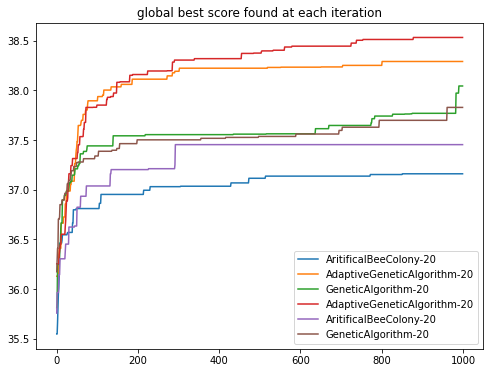

In [ ]:
from glob import glob
import os
mean_scores = []
labels = []
for path_name in glob("experiment/*"):
    file_name = os.path.basename(path_name).split('.')[0]
    solver, num_tour, population, _ = file_name.split('_')
    experiment = Experiment(None, None)
    experiment.load_experiment_results(path_name)
    

    mean_scores.append(experiment.get_mean_global_score_history())
    labels.append("{}-{}".format(solver[:-6], population))

    print("{}-{}".format(solver[:-6], population), "average result:", experiment.get_mean_result())
plt.figure(figsize=(16, 12))
plt.title("Global Best Score found at each Iteration")
for label, mean_score in zip(labels, mean_scores):
    plt.plot(mean_score, label=label)
_ = plt.legend()
    